In [1]:
%cd PathNNs_expressive/TUDatasets

/home/s223188874/PathNNs_expressive/TUDatasets


In [2]:
from model import PathNN
from utils import load_data, PathDataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools

In [3]:
%%bash
cd datasets
wget https://www.chrsmrrs.com/graphkerneldatasets/collab.zip

unzip collab.zip

Archive:  collab.zip
   creating: COLLAB/
  inflating: COLLAB/COLLAB_graph_labels.txt~  
  inflating: COLLAB/COLLAB_graph_indicator.txt  
  inflating: COLLAB/COLLAB_A.txt     
  inflating: COLLAB/COLLAB_graph_labels.txt  


--2024-08-24 18:49:31--  https://www.chrsmrrs.com/graphkerneldatasets/collab.zip
Resolving www.chrsmrrs.com... 217.160.0.75, 2001:8d8:100f:f000::258
Connecting to www.chrsmrrs.com|217.160.0.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.chrsmrrs.com/graphkerneldatasets/COLLAB.zip [following]
--2024-08-24 18:49:32--  https://www.chrsmrrs.com/graphkerneldatasets/COLLAB.zip
Reusing existing connection to www.chrsmrrs.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 74427494 (71M) [application/zip]
Saving to: ‘collab.zip’

     0K .......... .......... .......... .......... ..........  0%  100K 12m3s
    50K .......... .......... .......... .......... ..........  0%  200K 9m3s
   100K .......... .......... .......... .......... ..........  0%  392K 7m3s
   150K .......... .......... .......... .......... ..........  0%  500K 5m54s
   200K .......... .......... .......... .......... ..........  0%  529K 5m10s
   250K 

In [4]:
%%bash 
cd collab
wget https://raw.githubusercontent.com/diningphil/gnn-comparison/master/data_splits/COLLABORATIVE_DEGREE/COLLAB_splits.json

bash: line 1: cd: collab: No such file or directory
--2024-08-24 18:52:00--  https://raw.githubusercontent.com/diningphil/gnn-comparison/master/data_splits/COLLABORATIVE_DEGREE/COLLAB_splits.json
Resolving raw.githubusercontent.com... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289520 (283K) [text/plain]
Saving to: ‘COLLAB_splits.json’

     0K .......... .......... .......... .......... .......... 17% 16.8M 0s
    50K .......... .......... .......... .......... .......... 35% 16.2M 0s
   100K .......... .......... .......... .......... .......... 53%  212M 0s
   150K .......... .......... .......... .......... .......... 70% 22.4M 0s
   200K .......... .......... .......... .......... .......... 88% 73.0M 0s
   250K .......... .......... .......... ..                   100%  272M=0.009s

2024-08-24 18:52:01 (30.3 MB/s) - ‘COLLAB_splits.json’ save

### Load model and Data

Collab:


In [3]:
from importlib.util import module_for_loader
import networkx as nx
import numpy as np
import time
import pickle
import json
import scipy.sparse as sp
from math import ceil
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from random import randint
import logging
import os
import datetime
from collections import defaultdict

import torch
import torch.nn.init as init 
from torch.autograd import Variable 
import torch.nn.functional as F
from torch import optim
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

from torch_geometric.utils.convert import from_networkx
#from tqdm import tqdm
import tqdm
#from tqdm.contrib.logging import logging_redirect_tqdm

from torch_geometric.nn import GCN, GIN

from model import *
from utils import *

def train(model, data, criterion, optimizer):
    output = model(data)
    loss_train = criterion(output, data.y)
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    return output, loss_train

@torch.no_grad()
def test(model, data, criterion):
    output = model(data)
    loss_test = criterion(output, data.y)
    return output, loss_test


In [4]:
y = []
with open('datasets/COLLAB/COLLAB_graph_labels.txt', 'r') as f:
    y = [int(l) for l in f.readlines()]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
trainX, testX, trainY, testY = train_test_split(list(range(len(y))), y, test_size=0.2, stratify=y)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2, stratify=trainY)

data = [
    {
        "test": testX,
        "model_selection": [
            {
                "train": trainX,
                "validation": valX
            }
        ]
    }
]

with open('datasets/infectious_ct1/infectious_ct1_splits.json', 'w') as f:
    json.dump(data, f, indent=4)


In [4]:
device = torch.device("cuda") if all([torch.cuda.is_available()]) else torch.device("cpu")

if os.getcwd()[-10:] != 'TUDatasets': 
    os.chdir(os.path.dirname(os.getcwd()))

Gs, features, y, splits = load_data('COLLAB', False, False, False)

features_dim = features[0].shape[1]
n_classes = len(np.unique(y))
criterion = torch.nn.CrossEntropyLoss()

In [6]:
path_type='shortest_path'
batch_size=16
add_residuals=True
dataset_name='COLLAB'
cutoff=3
lr=1e-3
epochs=500
patience=250

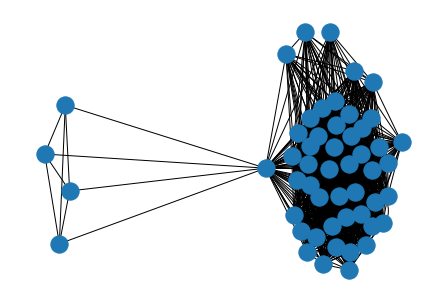

In [24]:
nx.draw(Gs[2])

In [7]:
if not os.path.exists(os.path.join('results', dataset_name)) : 
    os.makedirs(os.path.join('results', dataset_name))
if not os.path.exists(os.path.join('logs', dataset_name)) : 
    os.makedirs(os.path.join('logs', dataset_name))
if not os.path.exists(os.path.join('models', dataset_name)) : 
    os.makedirs(os.path.join('models', dataset_name))
now = "_" + "-".join(str(datetime.datetime.today()).split()).split('.')[0].replace(':','.')
residuals = '_residuals' if add_residuals else ''
program_name = "cutoff_"+str(cutoff)+"_path_"+str(path_type)+f'_bs_{batch_size}'+residuals+now

logging.basicConfig(filename=os.path.join('logs', dataset_name, program_name+'.log'), level=logging.INFO, filemode="w")
log = PrinterLogger(logging.getLogger(__name__) )

dataset = PathDataset(Gs, features, y, cutoff, path_type)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:13<00:00, 25.87it/s]


In [ ]:
accs_folds = list()
if path_type == 'all_simple_paths' : 
    encode_distances = True 
else : 
    encode_distances = False

np.random.seed(10)
torch.random.manual_seed(10) 
for it in range(5) : 
    log.info('-'*30+f'ITERATION {str(it+1)}'+"-"*30)
    print('-'*30+f'ITERATION {str(it+1)}'+"-"*30)
    train_index = splits[it]['model_selection'][0]['train']
    val_index = splits[it]['model_selection'][0]['validation']
    test_index = splits[it]['test']

    trainset = dataset[train_index]
    valset = dataset[val_index]
    testset = dataset[test_index]

    train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True, drop_last = validate_batch_size(len(trainset), batch_size))
    val_loader = DataLoader(valset, batch_size = batch_size, shuffle = False)
    test_loader = DataLoader(testset, batch_size = batch_size, shuffle = False)

    cnt = 1
    result_dict = defaultdict(list)
    best_acc_across_folds = -float(np.inf)
    best_loss_across_folds = float(np.inf)
    use_patience_loss = True if dataset_name == "MUTAG" else False
    grid_h =  [64, 32]
    grid_dropout = [0.5, 0]
    n_params = len(grid_dropout) * len(grid_h)
    for dropout in grid_dropout : 
        for hidden_dim in grid_h:   
            params = {"dropout":dropout, "hidden_dim": hidden_dim}

            model = PathNN(
                    features_dim, hidden_dim, cutoff, n_classes, dropout, device,
                    residuals = add_residuals, encode_distances=encode_distances
                    ).to(device)

            log.print_and_log(f'Model # Parameters {sum([p.numel() for p in model.parameters()])}')
            optimizer = optim.Adam(model.parameters(), lr=lr)
            early_stopper = Patience(patience = patience, use_loss = use_patience_loss)

            pbar_train = tqdm.tqdm(range(epochs), desc = "Epoch 0 Loss 0")
            for epoch in pbar_train:
                model.train()

                for idx, data in enumerate(train_loader):
                    data = data.to(device)
                    output, loss = train(model, data,criterion,optimizer)

                val_loss = 0
                val_correct = 0 
                model.eval()
                for idx, data in enumerate(val_loader):
                    output, loss = test(model, data.to(device),criterion)
                    val_loss += loss.item() * data.num_graphs
                    preds = output.max(1)[1].type_as(data.y)
                    val_correct += torch.sum(preds.eq(data.y.double())).item()


                val_acc = val_correct/len(val_loader.dataset)
                val_loss = val_loss / len(val_loader.dataset)

                if early_stopper.stop(epoch, val_loss, val_acc) : 
                    break

                best_acc_across_folds = early_stopper.val_acc if  early_stopper.val_acc > best_acc_across_folds else best_acc_across_folds
                best_loss_across_folds = early_stopper.val_loss if  early_stopper.val_loss < best_loss_across_folds else best_loss_across_folds

                pbar_train.set_description(f"MS {cnt}/{n_params} Epoch {epoch+1} Val loss {round(val_loss,3)} Val acc {round(val_acc,3)} Best Val Loss {round(early_stopper.val_loss, 3)} Best Val Acc {early_stopper.val_acc:0.3f} Best Fold Val Acc  {best_acc_across_folds:0.3f} Best Fold Val Loss {best_loss_across_folds:0.3f}")

            result_dict['config'].append(params)
            result_dict["best_val_acc"].append(early_stopper.val_acc)
            result_dict["best_val_loss"].append(early_stopper.val_loss)
            log.info(f"MS {cnt}/{n_params} Epoch {epoch+1} Val loss {round(val_loss,3)} Val acc {round(val_acc,3)} Best Val Loss {round(early_stopper.val_loss, 3)} Best Val Acc {early_stopper.val_acc:0.3f} Best Fold Val Acc  {best_acc_across_folds:0.3f} Best Fold Val Loss {best_loss_across_folds:0.3f}")

            cnt+=1

    ################################
    #         MODEL ASSESSMENT    #
    ###############################

    best_i = np.argmin(result_dict["best_val_loss"]) if use_patience_loss else np.argmax(result_dict["best_val_acc"]) 
    best_config = result_dict["config"][best_i]
    log.print_and_log(f"Winner of Model Selection | hidden dim: {best_config['hidden_dim']} | dropout {best_config['dropout']}")
    log.print_and_log(f"Winner Best Val Accuracy {result_dict['best_val_acc'][best_i]:0.5f}")

    test_accs = list() 
    cnt = 1

    model = PathNN(features_dim, best_config['hidden_dim'], cutoff, n_classes, best_config["dropout"], device,
                                 residuals = add_residuals, encode_distances=encode_distances).to(device)

    for jj in range(3) :

        model.reset_parameters()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        save_path = os.path.join('models', dataset_name, 'model_best_'+program_name+'.pth.tar')
        early_stopper = Patience(patience = patience, use_loss = use_patience_loss, save_path=save_path)

        pbar_train = tqdm.tqdm(range(epochs), desc = "Epoch 0 Loss 0")

        for epoch in pbar_train:
            model.train()

            for idx, data in enumerate(train_loader):
                data = data.to(device)
                output, loss = train(model, data,criterion,optimizer)

            val_loss = 0
            val_correct = 0 
            model.eval()
            for idx, data in enumerate(val_loader):
                output, loss = test(model, data.to(device),criterion)
                val_loss += loss.item() * data.num_graphs
                preds = output.max(1)[1].type_as(data.y)
                val_correct += torch.sum(preds.eq(data.y.double())).item()

            val_acc = val_correct/len(val_loader.dataset)
            val_loss = val_loss / len(val_loader.dataset)

            if early_stopper.stop(epoch, val_loss, val_acc, model = model) : 
                break

            pbar_train.set_description(f"Test {cnt}/3 Epoch {epoch+1} Val loss {round(val_loss,3)} Val acc {round(val_acc,3)} Best Val Loss {round(early_stopper.val_loss, 3)} Best Val Acc {early_stopper.val_acc:0.3f}")

        log.info(f"Test {cnt}/3 Epoch {epoch+1} Val loss {round(val_loss,3)} Val acc {round(val_acc,3)} Best Val Loss {round(early_stopper.val_loss, 3)} Best Val Acc {early_stopper.val_acc:0.3f}")

        checkpoint = torch.load(save_path)
        epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])

        test_loss = 0
        test_count = 0
        test_correct = 0
        model.eval()

        for idx, data in enumerate(test_loader):
            output, loss = test(model, data.to(device),criterion)
            test_loss += loss.item() * output.size(0)
            test_count += output.size(0)
            preds = output.max(1)[1].type_as(data.y)
            test_correct += torch.sum(preds.eq(data.y.double())).item()

        test_accs.append((test_correct/test_count))
        cnt+=1
    log.print_and_log(f"Avg test acc {np.mean(test_accs):.3f}, Agv test acc std {np.std(test_accs):.3f}")

    accs_folds.append((test_accs))

    log.print_and_log(f'Cross-val iter:{it+1} | Current average test accuracy across folds {np.mean(accs_folds):.5f}')
    log.print_and_log('\n')


accs_folds = np.asarray(accs_folds)

result_dict = {}
result_dict['test_accuracies'] = accs_folds
result_dict['best_params'] = best_config

with open(os.path.join('results', dataset_name, 'results_'+program_name+'.pkl'), 'wb') as f :
    pickle.dump(result_dict, f)

log.print_and_log(f"AVERAGE TEST ACC ACROSS FOLDS {np.mean(accs_folds):.5f}")  
log.print_and_log(f"STD ACROSS FOLDS {np.std(np.mean(accs_folds,axis = 1))}")


------------------------------ITERATION 1------------------------------
Model # Parameters 42435


MS 1/4 Epoch 91 Val loss 0.676 Val acc 0.669 Best Val Loss 0.672 Best Val Acc 0.707 Best Fold Val Acc  0.707 Best Fold Val Loss 0.642:  18%|███████████████████▋                                                                                        | 91/500 [11:11<50:34,  7.42s/it]

### Visualize Graphs & Metrics

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.average_shortest_path_length.html#networkx.algorithms.shortest_paths.generic.average_shortest_path_length

- **Node Connectivity**: Minimum number of nodes that need to be removed to disconnect the graph (calculated only if the graph is connected).
- **Diameter**: Maximum shortest path length between any pair of nodes in the graph (calculated only if the graph is connected).
- **Degree Assortativity Coefficient**: Correlation between the degrees of connected nodes.
- **Average Neighbor Degree**: Average degree of neighboring nodes for each node in the graph.
- **Average Degree Connectivity**: Average degree of nodes with a given degree.
- **Has Bridges**: Indicates if the graph contains any bridges (edges whose removal increases the number of connected components).
- **Triangles**: Number of triangles (3-cycles) for each node in the graph.
- **Transitivity**: Ratio of the number of triangles to the number of connected triples in the graph (global clustering coefficient).
- **Average Clustering**: Average local clustering coefficient across all nodes in the graph.
- **Is Connected**: Checks if the graph is connected (path exists between every pair of nodes).
- **Number of Connected Components**: Number of connected components (subgraphs where any two vertices are connected) in the graph.
- **Is Strongly Connected**: Checks if the graph is strongly connected (directed path from any node to every other node, for directed graphs only).
- **Number of Attracting Components**: Number of attracting components in a directed graph (subgraphs where every node can reach every other node within the subgraph).
- **Average Shortest Path Length**: Average shortest path length between all pairs of nodes in the graph (calculated only if the graph is connected).

In [5]:
data = list(zip(Gs, y))
G0 = [g for g, yy in data if yy == 0]
G1 = [g for g, yy in data if yy == 1]

In [ ]:
loader = DataLoader(dataset, batch_size = 32, shuffle = False)

In [ ]:
preds = []
model.eval()

with torch.no_grad():
    for idx, data in enumerate(loader):
        data = data.to('cuda:0')
        output = model(data)
        pred = output.argmax(dim=1).cpu()
        preds.append(pred)

preds = torch.cat(preds, dim=0)

In [ ]:
graph_stats = {}

for i, graph in enumerate(Gs):
    stats = {}
    
    # Calculate the required statistics
    stats['node_connectivity'] = nx.node_connectivity(graph) if nx.is_connected(graph) else None
    stats['diameter'] = nx.diameter(graph) if nx.is_connected(graph) else None
    stats['degree_assortativity_coefficient'] = nx.degree_assortativity_coefficient(graph)
    stats['average_neighbor_degree'] = nx.average_neighbor_degree(graph)
    stats['average_degree_connectivity'] = nx.average_degree_connectivity(graph)
    stats['has_bridges'] = nx.has_bridges(graph)
    stats['triangles'] = nx.triangles(graph)
    stats['transitivity'] = nx.transitivity(graph)
    stats['average_clustering'] = nx.average_clustering(graph)
    stats['is_connected'] = nx.is_connected(graph)
    stats['number_connected_components'] = nx.number_connected_components(graph)
    stats['is_strongly_connected'] = nx.is_strongly_connected(graph) if graph.is_directed() else None
    stats['number_attracting_components'] = nx.number_attracting_components(graph) if graph.is_directed() else None
#     stats['girth'] = nx.cycles.girth(graph) if nx.is_connected(graph) else None
    stats['average_shortest_path_length'] = nx.average_shortest_path_length(graph) if nx.is_connected(graph) else None
    
    # Store the statistics in the dictionary using the graph index as the key
    graph_stats[i] = stats


/opt/python/3.9/anaconda/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [ ]:
df = pd.DataFrame(graph_stats).transpose()

# Set up the plotting environment
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

plt.subplot(2, 3, 1)
sns.boxplot(data=df['node_connectivity'].dropna())
plt.title('Node Connectivity')
plt.ylabel('Node Connectivity')

plt.subplot(2, 3, 2)
sns.boxplot(data=df['diameter'].dropna())
plt.title('Diameter')
plt.ylabel('Diameter')

plt.subplot(2, 3, 3)
sns.histplot(data=df['degree_assortativity_coefficient'])
plt.title('Degree Assortativity Coefficient')
plt.ylabel('Degree Assortativity Coefficient')

import itertools
plt.subplot(2, 3, 4)
sns.boxplot(data=list(itertools.chain(*df['average_neighbor_degree'].apply(lambda x: list(x.values())))))
plt.title('Average Neighbor Degree')
plt.ylabel('Average Neighbor Degree')

# plt.subplot(2, 3, 5)
# sns.boxplot(data=df['average_degree_connectivity'].dropna())
# plt.title('Average Degree Connectivity')
# plt.ylabel('Average Degree Connectivity')


plt.subplot(2, 3, 5)
sns.histplot(data=df['has_bridges'].astype(str))
plt.title('Has Bridges')
plt.ylabel('Has Bridges')



plt.subplot(2, 3, 6)
sns.boxplot(data=df['average_clustering'].dropna())
plt.title('Average Clustering')
plt.ylabel('Average Clustering')



plt.subplot(2, 3, 5)
sns.histplot(data=df['has_bridges'].astype(str))
plt.title('Has Bridges')
plt.ylabel('Has Bridges')

plt.tight_layout()
plt.show()


In [ ]:
df

In [ ]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Ensure 'has_bridges' is treated as a categorical column
df['has_bridges'] = df['has_bridges'].astype(str)

# Function to calculate statistics for a list of graphs
def calculate_graph_stats(Gs, label):
    graph_stats = []
    for i, graph in enumerate(Gs):
        stats = {}
        stats['label'] = label
        stats['node_connectivity'] = nx.node_connectivity(graph) if nx.is_connected(graph) else None
        stats['diameter'] = nx.diameter(graph) if nx.is_connected(graph) else None
        stats['degree_assortativity_coefficient'] = nx.degree_assortativity_coefficient(graph)
        stats['average_neighbor_degree'] = nx.average_neighbor_degree(graph)
        stats['average_degree_connectivity'] = nx.average_degree_connectivity(graph)
        stats['has_bridges'] = nx.has_bridges(graph)
        stats['triangles'] = nx.triangles(graph)
        stats['transitivity'] = nx.transitivity(graph)
        stats['average_clustering'] = nx.average_clustering(graph)
        stats['is_connected'] = nx.is_connected(graph)
        stats['number_connected_components'] = nx.number_connected_components(graph)
        stats['is_strongly_connected'] = nx.is_strongly_connected(graph) if graph.is_directed() else None
        stats['number_attracting_components'] = nx.number_attracting_components(graph) if graph.is_directed() else None
        stats['average_shortest_path_length'] = nx.average_shortest_path_length(graph) if nx.is_connected(graph) else None
        graph_stats.append(stats)
    return pd.DataFrame(graph_stats)

# Calculate statistics for both sets of graphs
df_G0 = calculate_graph_stats(G0, label=0)
df_G1 = calculate_graph_stats(G1, label=1)

# Combine the two DataFrames
df = pd.concat([df_G0, df_G1])

# Adjust for plotting average neighbor degree
avg_neighbor_degree_data = []
for index, row in df.iterrows():
    for node, degree in row['average_neighbor_degree'].items():
        avg_neighbor_degree_data.append({
            'label': row['label'],
            'average_neighbor_degree': degree
        })
avg_neighbor_degree_df = pd.DataFrame(avg_neighbor_degree_data)

# Plotting
plt.figure(figsize=(20, 15))
sns.set(style="whitegrid")

plt.subplot(2, 3, 1)
sns.boxplot(x='label', y='node_connectivity', data=df.dropna(subset=['node_connectivity']))
plt.title('Node Connectivity')
plt.ylabel('Node Connectivity')

plt.subplot(2, 3, 2)
sns.boxplot(x='label', y='diameter', data=df.dropna(subset=['diameter']))
plt.title('Diameter')
plt.ylabel('Diameter')

plt.subplot(2, 3, 3)
sns.boxplot(x='label', y='degree_assortativity_coefficient', data=df)
plt.title('Degree Assortativity Coefficient')
plt.ylabel('Degree Assortativity Coefficient')

plt.subplot(2, 3, 4)
sns.boxplot(x='label', y='average_neighbor_degree', data=avg_neighbor_degree_df)
plt.title('Average Neighbor Degree')
plt.ylabel('Average Neighbor Degree')

plt.subplot(2, 3, 5)
sns.boxplot(data=df, x='has_bridges', y='label')
plt.title('Has Bridges')
plt.ylabel('Count')

plt.subplot(2, 3, 6)
sns.boxplot(x='label', y='average_clustering', data=df.dropna(subset=['average_clustering']))
plt.title('Average Clustering')
plt.ylabel('Average Clustering')

plt.tight_layout()
plt.show()


In [ ]:
import math 

n=100

cols = min(math.ceil(math.sqrt(n)), 4)
rows = math.ceil(n / cols) 

plt.figure(figsize=(cols * 5, rows * 5))

for i in range(n):
    plt.subplot(rows, cols, i + 1)  # Create subplot in the grid
    color = '#1f78b4' if y[i] == 0 else '#b41f3f'
    nx.draw(Gs[i], with_labels=True, node_color=color)  # Draw the graph
    plt.title(f'label: {y[i]}')
    
plt.tight_layout()
plt.show()

In [32]:
!ls datasets

DD	 IMDB-BINARY  NCI1	downdload_data.sh  infectious_ct1.zip
ENZYMES  IMDB-MULTI   PROTEINS	infectious_ct1


In [33]:
node_labels = pd.read_csv(f"datasets/infectious_ct1/infectious_ct1_node_labels.txt", header=None, names=range(4), dtype=str)
node_labels = node_labels.applymap(lambda x: pd.to_numeric(x, errors='coerce'))

### UMAP visualization

In [148]:
!pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 85 kB 246 kB/s eta 0:00:011
     |████████████████████████████████| 56 kB 2.8 MB/s  eta 0:00:01


In [68]:
import torch
import umap
import matplotlib.pyplot as plt

hidden_representations = []

def hook_fn(module, input, output):
    hidden_representations.append(output.cpu().detach())

hook = model.linear1.register_forward_hook(hook_fn)

model.eval()

with torch.no_grad():
    for idx, data in enumerate(loader):
        data = data.to('cuda:0')
        output = model(data)

hook.remove()

hidden_representations = torch.cat(hidden_representations, dim=0)

/home/s223188874/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/s223188874/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/s223188874/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/s223188874/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for paralleli

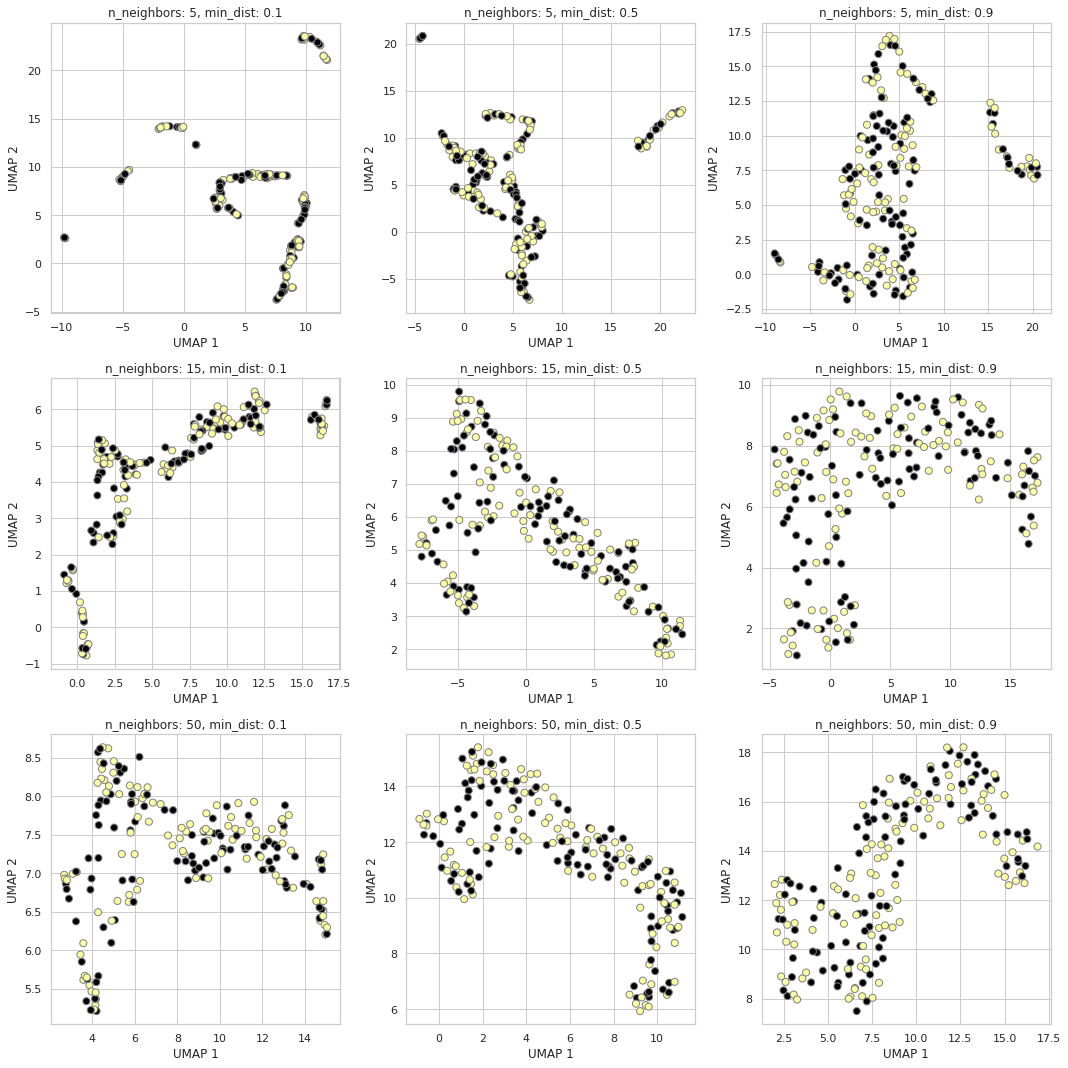

In [69]:
import umap
import matplotlib.pyplot as plt
import numpy as np

n_neighbors_values = [5, 15, 50]
min_dist_values = [0.1, 0.5, 0.9]

fig, axes = plt.subplots(len(n_neighbors_values), len(min_dist_values), figsize=(15, 15))

for i, n_neighbors in enumerate(n_neighbors_values):
    for j, min_dist in enumerate(min_dist_values):
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)
        embedding = reducer.fit_transform(hidden_representations.numpy())

        ax = axes[i, j]
        ax.scatter(embedding[:, 0], embedding[:, 1], c=y, s=50, cmap='inferno', edgecolors='gray')
        ax.set_title(f"n_neighbors: {n_neighbors}, min_dist: {min_dist}")
        ax.set_xlabel("UMAP 1")
        ax.set_ylabel("UMAP 2")

plt.tight_layout()
plt.show()
